In [1]:
import random

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    # total tracking of max values
    'tot_energy_prod_cap': 0, # total energy produced by the system
    'tot_energy_appetite_priority': 0, # amount of energy appetite
    'tot_energy_appetite_business': 0, # amount of energy appetite
    'tot_energy_appetite_leisure': 0, # amount of energy appetite
    # total tracking of actual usage
    'tot_energy_cons': 0, # total energy consumed
    'tot_energy_cons_priority': 0, # amount of energy consumed
    'tot_energy_cons_business': 0, # amount of energy consumed
    'tot_energy_cons_leisure': 0, # amount of energy consumed
    'tot_bat_use': 0,
    # time tracking
    'hour_of_day': 0, # 24 hour days
    'day_number': 0, # number of days passed tracker
    # timestep energy tracking
    't_energy_prod_cap': 0, # amount of energy the solartainer can produce this timestep
    't_energy_cons': 0,
    # limited mechanics tracking
    'bat_level': 0, # amount of energy currently stored in the battery  
    'bat_lim': 10, # kWh
    'max_price_per_kwh': 0.13 # EUR cents
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# `M` is not currently used
simulation_parameters = {
    'T': range(10),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# Specify the Solartainer production and battery logic in a Policy function
def solartainer_produce(params, step, sL, s):
    # calculate production from random variables
    # based on timestep add:
        # annual production variance
        # daily production variance
        # hourly production variance
    t_energy_prod_cap = 7 # random.random()*5
    return({'t_energy_prod_cap': t_energy_prod_cap})

# Specify the user of electricity logic in a Policy function
def consume_electricity(params, step, sL, s, energy_appetite, use_bat):
    print('step', step)
    print('available', s['t_energy_prod_cap'], s['t_energy_cons'])
    energy_avail_prod = s['t_energy_prod_cap'] - s['t_energy_cons']
    energy_cons_prod = min(energy_avail_prod, energy_appetite)
    if use_bat:
        energy_cons_bat = min(energy_appetite, s['bat_level'])
    else:
        energy_cons_bat = 0
    print('used:', energy_cons_prod, energy_cons_bat)
    return(energy_cons_prod, energy_cons_bat)

def userGroup_priority(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite =  3 #random.random()*2
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_priority': energy_appetite,
            'energy_cons_priority': energy_cons, 
            't_energy_cons': energy_cons, 
            'energy_cons_bat': energy_cons_bat})

def userGroup_business(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite =  2 #random.random()*1
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_business': energy_appetite,
            'energy_cons_business': energy_cons, 
            't_energy_cons': energy_cons, 
            'energy_cons_bat': energy_cons_bat})

def userGroup_leisure(params, step, sL, s):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite = 1 #random.random()*1
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    energy_cons = energy_cons_prod + energy_cons_bat
    return({'energy_appetite_leisure': energy_appetite,
            'energy_cons_leisure': energy_cons, 
            't_energy_cons': energy_cons, 
            'energy_cons_bat': energy_cons_bat})

# Specify the actions of the battery based on leftover electricity
def battery_tracker(params, step, sL, s):
    # calculate energy appetite based on battery cap
    energy_appetite = s['bat_lim'] - s['bat_level']
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=False)
    energy_cons = energy_cons_prod
    return({'energy_cons_bybat': energy_cons,
            't_energy_cons': energy_cons})

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the amount of electricity produced / consumed
# (which, per the policy function definition, may be negative)

# update potential max values
def increment_tot_energy_prod_cap(params, step, sL, s, _input):
    y = 'tot_energy_prod_cap'
    x = s['tot_energy_prod_cap'] + _input['t_energy_prod_cap']
    return (y, x)

def increment_t_energy_prod_cap(params, step, sL, s, _input):
    y = 't_energy_prod_cap'
    x = _input['t_energy_prod_cap']
    return (y, x)

def increment_tot_energy_appetite_priority(params, step, sL, s, _input):
    y = 'tot_energy_appetite_priority'
    x = s['tot_energy_appetite_priority'] + _input['energy_appetite_priority']
    return (y, x)

def increment_tot_energy_appetite_business(params, step, sL, s, _input):
    y = 'tot_energy_appetite_business'
    x = s['tot_energy_appetite_business'] + _input['energy_appetite_business']
    return (y, x)

def increment_tot_energy_appetite_leisure(params, step, sL, s, _input):
    y = 'tot_energy_appetite_leisure'
    x = s['tot_energy_appetite_leisure'] + _input['energy_appetite_leisure']
    return (y, x)

# update actual use values
def increment_tot_energy_cons(params, step, sL, s, _input):
    y = 'tot_energy_cons'
    x = s['tot_energy_cons'] + _input['t_energy_cons']
    return (y, x)

def increment_tot_energy_cons_priority(params, step, sL, s, _input):
    y = 'tot_energy_cons_priority'
    x = s['tot_energy_cons_priority'] + _input['energy_cons_priority']
    return (y, x)

def increment_tot_energy_cons_business(params, step, sL, s, _input):
    y = 'tot_energy_cons_business'
    x = s['tot_energy_cons_business'] + _input['energy_cons_business']
    return (y, x)

def increment_tot_energy_cons_leisure(params, step, sL, s, _input):
    y = 'tot_energy_cons_leisure'
    x = s['tot_energy_cons_leisure'] + _input['energy_cons_leisure']
    return (y, x)

# update tot battery usage
def increment_tot_bat_use(params, step, sL, s, _input):
    y = 'tot_bat_use'
    x = s['tot_bat_use'] + _input['energy_cons_bat']
    return (y, x)

# update battery state
def increment_bat_level(params, step, sL, s, _input):
    y = 'bat_level'
    x = s['bat_level'] + _input['energy_cons_bybat'] - _input['energy_cons_bat']
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 





# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'solartainer_produce': solartainer_produce,
            'userGroup_priority': userGroup_priority,
            'userGroup_business': userGroup_business,
            'userGroup_leisure': userGroup_leisure,
            'battery_tracker': battery_tracker
        },
        'variables': { # The following state variables will be updated simultaneously
            'tot_energy_prod_cap': increment_tot_energy_prod_cap,
            't_energy_prod_cap': increment_t_energy_prod_cap,
            'tot_energy_appetite_priority': increment_tot_energy_appetite_priority,
            'tot_energy_appetite_business': increment_tot_energy_appetite_business,
            'tot_energy_appetite_leisure': increment_tot_energy_appetite_leisure,
            'tot_energy_cons': increment_tot_energy_cons,
            'tot_energy_cons_priority': increment_tot_energy_cons_priority,
            'tot_energy_cons_business': increment_tot_energy_cons_business,
            'tot_energy_cons_leisure': increment_tot_energy_cons_leisure,
            'tot_bat_use': increment_tot_bat_use,
            'bat_level': increment_bat_level
            
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x000001AB331D7128>]
Configurations: [<cadCAD.configuration.Configuration object at 0x000001AB331D7128>]
step 1
available 0 0
used: 0 0
step 1
available 0 0
used: 0 0
step 1
available 0 0
used: 0 0
step 1
available 0 0
used: 0 0
step 1
available 7 0
used: 7 0
step 1
available 7 0
used: 2 0
step 1
available 7 0
used: 1 0
step 1
available 7 0
used: 3 0
step 1
available 7 0
used: 3 0
step 1
available 7 0
used: 2 2
step 1
available 7 0
used: 1 1
step 1
available 7 0
used: 3 3
step 1
available 7 0
used: 6 0
step 1
available 7 0
used: 2 2
step 1
available 7 0
used: 1 1
step 1
available 7 0
used: 3 3
step 1
available 7 0
used: 6 0
step 1
available 7 0
us

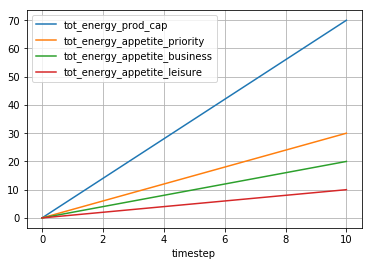

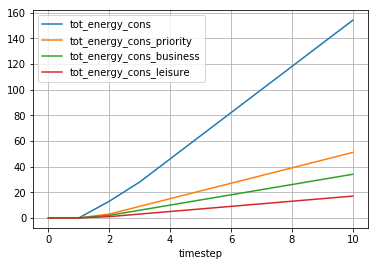

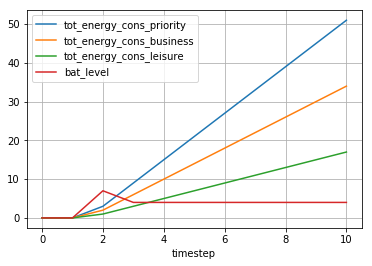

In [3]:
df.plot('timestep', ['tot_energy_prod_cap', 'tot_energy_appetite_priority', 'tot_energy_appetite_business', 'tot_energy_appetite_leisure'], grid=True);
df.plot('timestep', ['tot_energy_cons', 'tot_energy_cons_priority', 'tot_energy_cons_business', 'tot_energy_cons_leisure'], grid=True);
df.plot('timestep', ['tot_energy_cons_priority', 'tot_energy_cons_business', 'tot_energy_cons_leisure', 'bat_level'], grid=True);